In [14]:
from sam.stress_addition_model import (
    sam_prediction,
    get_sam_lcs,
    OLD_STANDARD,
    dose_response_fit,
    FitSettings
)
from sam.plotting import plot_sam_prediction
from sam.data_formats import load_datapoints
import os
import matplotlib.pyplot as plt
import pandas as pd
import argparse
from tqdm import tqdm
from sam import chdir_to_repopath
import numpy as np
chdir_to_repopath()

In [52]:
datastuff = []

for path, data, name, val in tqdm(load_datapoints()):

    cfg = FitSettings(
        survival_max=data.meta.max_survival,
        param_d_norm= True,
        len_curves=100
    )

    main_fit = dose_response_fit(data.main_series, cfg)
    stress_fit = dose_response_fit(val, cfg)
    
    datastuff.append((
        data,
        path,
        name,
        main_fit,
        stress_fit,
    ))

100%|██████████| 47/47 [00:00<00:00, 68.61it/s]


In [53]:
concentrations = np.array([(i[-2].concentration_curve)/ i[-2].lc99 for i in datastuff])
dosiswirkung = np.array([i[-2].survival_curve / i[0].meta.max_survival for i in datastuff])
stress_kontrollen = np.array([i[-1].inputs.survival_rate[0] / i[0].meta.max_survival for i in datastuff])
label = np.array([i[-1].survival_curve / i[0].meta.max_survival for i in datastuff])

stress_kontrollen = np.repeat(stress_kontrollen[:,None], concentrations.shape[1], axis=1)

label.min(), label.max(), concentrations.max(), concentrations.min()

(3.262919584564543e-26,
 0.9999999083269013,
 2.190726565168298,
 3.5605451498251987e-09)

In [54]:
np.random.seed(0)

val_ser = np.random.choice(len(concentrations), int(len(concentrations) * 0.2), replace=False)
mask = np.isin(np.arange(len(concentrations)) , val_ser)

X = np.stack([
    concentrations,
    dosiswirkung,
    stress_kontrollen
], axis= -1)

x_train, x_test = X[~mask].reshape(-1, 3), X[mask].reshape(-1, 3)
y_train, y_test = label[~mask].reshape(-1), label[mask].reshape(-1)

In [61]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Define the models, including slightly more complex ones
models = [
    ("Linear Regression", LinearRegression()),
    ("Ridge Regression", Ridge(alpha=1.0)),
    ("Lasso Regression", Lasso(alpha=0.1)),
    ("Decision Tree Regressor", DecisionTreeRegressor(max_depth=5)),
    ("K-Nearest Neighbors", KNeighborsRegressor(n_neighbors=5)),
    ("Support Vector Regressor", SVR(kernel='rbf', C=1.0, epsilon=0.1)),  # Slightly more complex and smooth
    ("Random Forest Regressor", RandomForestRegressor(n_estimators=50, max_depth=5)),  # Ensemble, smooth by averaging
    ("Polynomial Regression (degree 2)", make_pipeline(PolynomialFeatures(degree=2), LinearRegression())),  # degree 2 polynomial
    ("Polynomial Regression (degree 3)", make_pipeline(PolynomialFeatures(degree=3), LinearRegression())),   # degree 3 polynomial
]

In [62]:
results = []

# Loop over models
for name, model in models:
    # Train the model
    model.fit(x_train, y_train)
    
    # Predict
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    
    # Evaluate using R² score
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    
    # Append results
    results.append((name, r2_train, r2_test))

In [63]:
results_df = pd.DataFrame(results, columns=["Model", "R² Train", "R² Test"])
results_df

,Model,R² Train,R² Test
0,Linear Regression,0.874683,0.867798
1,Ridge Regression,0.874650,0.868392
2,Lasso Regression,0.000000,-0.016072
3,Decision Tree Regressor,0.951807,0.879495
4,K-Nearest Neighbors,0.982009,0.820785
5,Support Vector Regressor,0.916059,0.908181
6,Random Forest Regressor,0.963002,0.903103
7,Polynomial Regression (degree 2),0.917165,0.898706
8,Polynomial Regression (degree 3),0.923484,0.895489


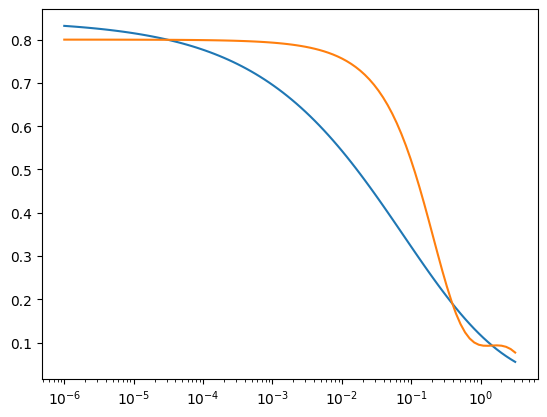

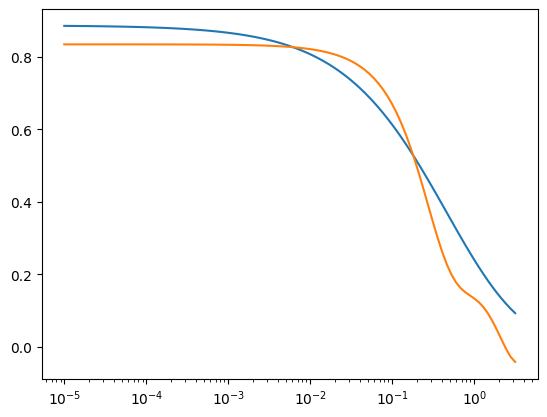

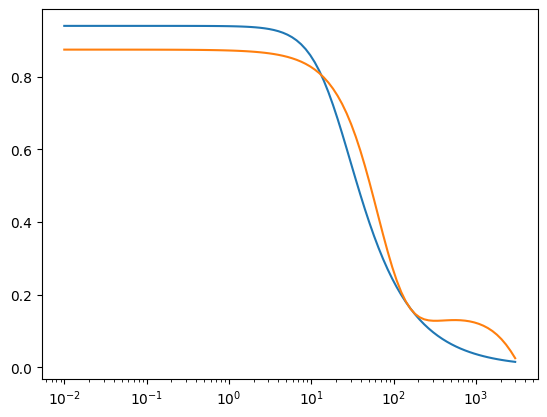

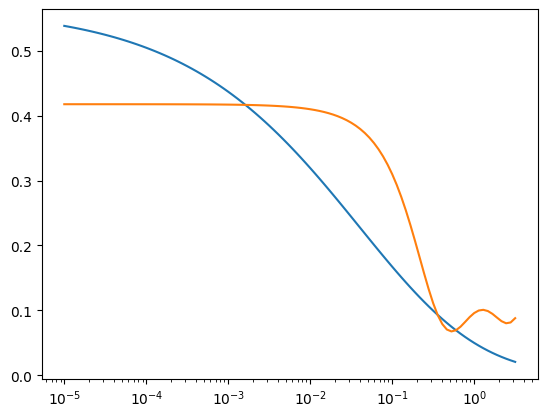

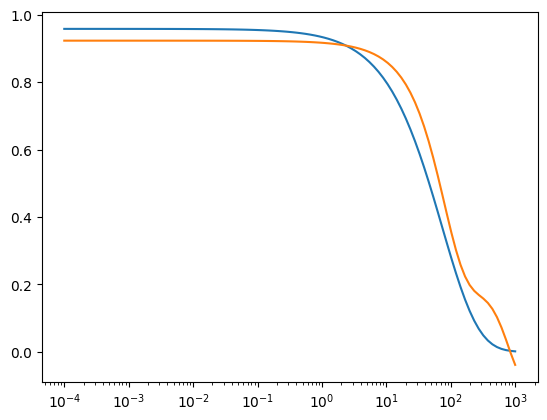

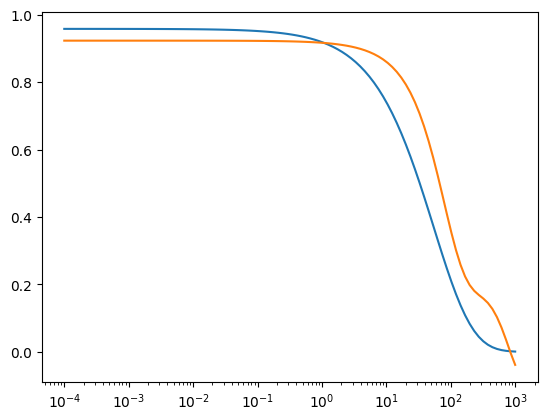

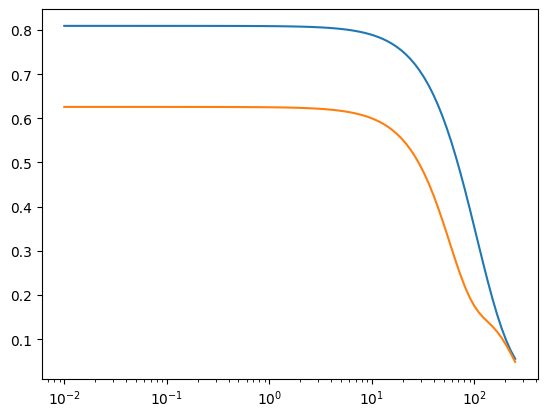

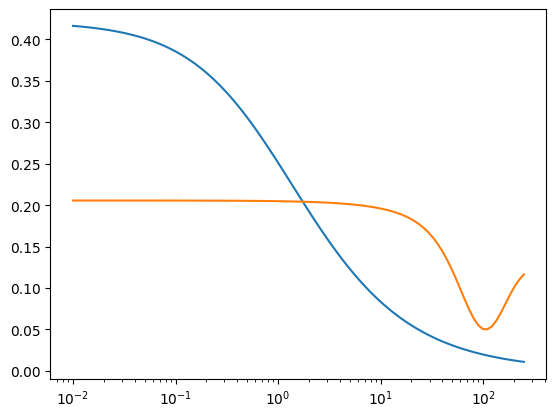

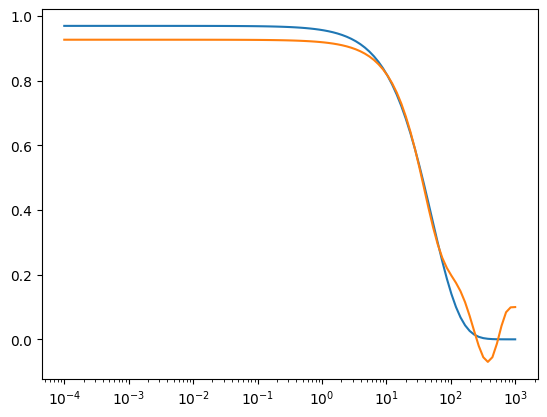

In [67]:
model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
model.fit(x_train, y_train)

og_concentrations = np.array([i[-2].concentration_curve for i in datastuff])[mask]

y_pred = model.predict(x_test).reshape(9, 100)

for y, p, x in zip(y_test.reshape(9, 100), y_pred, og_concentrations):
    plt.plot(x, y)
    plt.plot(x, p)
    plt.xscale("log")
    plt.show()
